In [356]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, TimeDistributed, Input
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [357]:
# --- Configuration ---
DATASET_PATH = Path("data_split") # Path to the folder with pre-split CSVs

# Model and feature configurations
dynamic_feature_cols = ['flops', 'non_zero_params', 'params_reduction_pct', 'flops_reduction_pct']
target_col = 'overall_accuracy'
INTERMEDIATE_THRESHOLDS = np.round(np.arange(0.1, 10.0, 0.1), 1) # 99 points
RANDOM_STATE = 42

tf.random.set_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

In [358]:
# --- Helper Function to Prepare Sequences (WITH acc_10 as input) ---
def prepare_sequences_from_df_with_acc10(df, dynamic_cols, target_col_name, intermediate_thresholds_list):
    """
    Prepares X and y sequences from a given DataFrame.
    X includes acc_0 and acc_10 as static repeated features.
    Also returns a dictionary of actual acc@10 values and model_ids.
    """
    X_list_local = []
    y_list_local = []
    # actual_acc10_dict_local = {} # acc_10 is now an input, but we might still want actuals for plotting comparison
    processed_model_info_local = [] # Stores (model_id, acc_0, acc_10) for unscaled X during prediction
    skipped_count_local = 0

    for model_id, group in df.groupby('model_id'):
        group = group.sort_values(by='threshold').reset_index(drop=True)

        acc_at_0_series = group[group['threshold'] == 0.0][target_col_name]
        acc_at_10_series = group[group['threshold'] == 10.0][target_col_name]

        if acc_at_0_series.empty or acc_at_10_series.empty:
            skipped_count_local += 1
            continue
        
        acc_0_val = acc_at_0_series.iloc[0]
        acc_10_val = acc_at_10_series.iloc[0] # acc_10 is now an input
        # actual_acc10_dict_local[model_id] = acc_10_val

        intermediate_data = group[group['threshold'].isin(intermediate_thresholds_list)].copy()
        if len(intermediate_data) != len(intermediate_thresholds_list):
            skipped_count_local += 1
            continue
        intermediate_data = intermediate_data.sort_values(by='threshold').reset_index(drop=True)

        current_dynamic_features = intermediate_data[dynamic_cols].values
        acc_0_feature_repeated = np.tile(acc_0_val, (len(intermediate_thresholds_list), 1))
        acc_10_feature_repeated = np.tile(acc_10_val, (len(intermediate_thresholds_list), 1)) # New input feature

        lagged_accuracies = np.zeros((len(intermediate_thresholds_list), 1))
        lagged_accuracies[0] = acc_0_val
        if len(intermediate_thresholds_list) > 1:
            lagged_accuracies[1:] = intermediate_data[target_col_name].values[:-1].reshape(-1,1)

        # Order: dynamic_features, acc_0_static_repeated, acc_10_static_repeated, lagged_actual_accuracy
        model_X_sample = np.concatenate([
            current_dynamic_features,
            acc_0_feature_repeated,
            acc_10_feature_repeated, # ADDED acc_10 feature
            lagged_accuracies
        ], axis=1)
        X_list_local.append(model_X_sample)

        model_y_sample = intermediate_data[target_col_name].values.reshape(-1, 1)
        y_list_local.append(model_y_sample)
        
        # Store original model_id and the unscaled acc0, acc10 for easier access during prediction
        processed_model_info_local.append({
            'model_id': model_id,
            'acc_0': acc_0_val,
            'acc_10': acc_10_val
        })
        
    if not X_list_local:
        raise ValueError(f"No valid sequences prepared from the provided DataFrame. Skipped {skipped_count_local} models.")
    
    print(f"From DataFrame, prepared {len(X_list_local)} sequences (with acc_10 input), skipped {skipped_count_local} models.")
    return np.array(X_list_local), np.array(y_list_local), processed_model_info_local

In [359]:
# --- 1. Load Pre-split Datasets ---
print("Loading pre-split datasets...")
try:
    train_df_raw = pd.read_csv(DATASET_PATH / "train_dataset.csv")
    validation_df_raw = pd.read_csv(DATASET_PATH / "validation_dataset.csv")
except FileNotFoundError as e:
    print(f"Error: Dataset file not found. Make sure '{e.filename}' exists.")
    print(f"Please run the `prepare_datasets.py` script first to generate these files in '{DATASET_PATH}'.")
    exit()

# Round the threshold column to fix precision issues
print("Rounding threshold column to 1 decimal place...")
train_df = train_df_raw.copy()
train_df['threshold'] = train_df['threshold'].round(1)
validation_df = validation_df_raw.copy()
validation_df['threshold'] = validation_df['threshold'].round(1)

print(f"Training data shape (after rounding): {train_df.shape}")
print(f"Validation data shape (after rounding): {validation_df.shape}")

Loading pre-split datasets...
Rounding threshold column to 1 decimal place...
Training data shape (after rounding): (1313, 18)
Validation data shape (after rounding): (202, 18)


In [360]:
# --- 2. Prepare Sequences for Training and Validation Data (WITH acc_10 input) ---
print("\nPreparing training sequences (with acc_10 input)...")
X_train_all_samples, y_train_all_samples, train_model_info = \
    prepare_sequences_from_df_with_acc10(train_df, dynamic_feature_cols, target_col, INTERMEDIATE_THRESHOLDS)

print("\nPreparing validation sequences (with acc_10 input)...")
X_val_all_samples, y_val_all_samples, val_model_info = \
    prepare_sequences_from_df_with_acc10(validation_df, dynamic_feature_cols, target_col, INTERMEDIATE_THRESHOLDS)

print(f"\nTraining data for LSTM: X_train_all_samples shape: {X_train_all_samples.shape}, y_train_all_samples shape: {y_train_all_samples.shape}")
print(f"Validation data for LSTM: X_val_all_samples shape: {X_val_all_samples.shape}, y_val_all_samples shape: {y_val_all_samples.shape}")


Preparing training sequences (with acc_10 input)...
From DataFrame, prepared 13 sequences (with acc_10 input), skipped 0 models.

Preparing validation sequences (with acc_10 input)...
From DataFrame, prepared 2 sequences (with acc_10 input), skipped 0 models.

Training data for LSTM: X_train_all_samples shape: (13, 99, 7), y_train_all_samples shape: (13, 99, 1)
Validation data for LSTM: X_val_all_samples shape: (2, 99, 7), y_val_all_samples shape: (2, 99, 1)


In [361]:
# --- 3. Scaling (Fit on Training Data ONLY, then Transform Both) ---
num_dynamic_features = len(dynamic_feature_cols)
# num_acc_like_features_in_X is now 3 (acc_0_feat, acc_10_feat, lagged_acc_feat)
num_acc_like_features_in_X = 3

# -- Scaler for dynamic features --
x_dynamic_scaler = MinMaxScaler()
X_train_dynamic_part_reshaped = X_train_all_samples[:, :, :num_dynamic_features].reshape(-1, num_dynamic_features)
x_dynamic_scaler.fit(X_train_dynamic_part_reshaped)
X_train_dynamic_part_scaled_reshaped = x_dynamic_scaler.transform(X_train_dynamic_part_reshaped)
X_train_dynamic_part_scaled = X_train_dynamic_part_scaled_reshaped.reshape(X_train_all_samples.shape[0], X_train_all_samples.shape[1], num_dynamic_features)
X_val_dynamic_part_reshaped = X_val_all_samples[:, :, :num_dynamic_features].reshape(-1, num_dynamic_features)
X_val_dynamic_part_scaled_reshaped = x_dynamic_scaler.transform(X_val_dynamic_part_reshaped)
X_val_dynamic_part_scaled = X_val_dynamic_part_scaled_reshaped.reshape(X_val_all_samples.shape[0], X_val_all_samples.shape[1], num_dynamic_features)

# -- Scaler for accuracy-like features --
y_acc_scaler = MinMaxScaler()
train_acc_feat_col_idx_start = num_dynamic_features
train_x_acc_features_part = X_train_all_samples[:, :, train_acc_feat_col_idx_start : train_acc_feat_col_idx_start + num_acc_like_features_in_X]
train_all_x_acc_features_flat = train_x_acc_features_part.flatten()
train_all_y_values_flat = y_train_all_samples.flatten()
train_all_acc_values_for_fitting = np.concatenate([train_all_x_acc_features_flat, train_all_y_values_flat])
y_acc_scaler.fit(train_all_acc_values_for_fitting.reshape(-1, 1))

X_train_acc_part_scaled_list = []
for i in range(num_acc_like_features_in_X):
    current_acc_feature_col_idx = num_dynamic_features + i
    acc_feature_column_data = X_train_all_samples[:, :, current_acc_feature_col_idx]
    scaled_column_reshaped = y_acc_scaler.transform(acc_feature_column_data.reshape(-1, 1))
    X_train_acc_part_scaled_list.append(scaled_column_reshaped.reshape(X_train_all_samples.shape[0], X_train_all_samples.shape[1], 1))
X_train_acc_part_scaled = np.concatenate(X_train_acc_part_scaled_list, axis=2)
y_train_scaled_reshaped = y_acc_scaler.transform(y_train_all_samples.reshape(-1, 1))
y_train_scaled = y_train_scaled_reshaped.reshape(y_train_all_samples.shape)

X_val_acc_part_scaled_list = []
for i in range(num_acc_like_features_in_X):
    current_acc_feature_col_idx = num_dynamic_features + i
    acc_feature_column_data = X_val_all_samples[:, :, current_acc_feature_col_idx]
    scaled_column_reshaped = y_acc_scaler.transform(acc_feature_column_data.reshape(-1, 1))
    X_val_acc_part_scaled_list.append(scaled_column_reshaped.reshape(X_val_all_samples.shape[0], X_val_all_samples.shape[1], 1))
X_val_acc_part_scaled = np.concatenate(X_val_acc_part_scaled_list, axis=2)
y_val_scaled_reshaped = y_acc_scaler.transform(y_val_all_samples.reshape(-1, 1))
y_val_scaled = y_val_scaled_reshaped.reshape(y_val_all_samples.shape)

X_train_scaled = np.concatenate([X_train_dynamic_part_scaled, X_train_acc_part_scaled], axis=2)
X_val_scaled = np.concatenate([X_val_dynamic_part_scaled, X_val_acc_part_scaled], axis=2)

print(f"\nScaled Training X shape: {X_train_scaled.shape}, Scaled Training y shape: {y_train_scaled.shape}")
print(f"Scaled Validation X shape: {X_val_scaled.shape}, Scaled Validation y shape: {y_val_scaled.shape}")


Scaled Training X shape: (13, 99, 7), Scaled Training y shape: (13, 99, 1)
Scaled Validation X shape: (2, 99, 7), Scaled Validation y shape: (2, 99, 1)


In [362]:
# --- 4. Build LSTM Model ---
sequence_length = X_train_scaled.shape[1]
n_features_per_step = X_train_scaled.shape[2]
total_features = num_dynamic_features + num_acc_like_features_in_X

model = Sequential([
    Input(shape=(sequence_length, n_features_per_step)),
    LSTM(units=14, return_sequences=True),
    LSTM(units=7, return_sequences=True),
    TimeDistributed(Dense(units=1))
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])
model.summary()

Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_70 (LSTM)                  │ (None, 99, 14)         │         1,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_71 (LSTM)                  │ (None, 99, 7)          │           616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_27             │ (None, 99, 1)          │             8 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,856 (7.25 KB)

 Trainable params: 1,856 (7.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.6062 - mae: 0.6653 - val_loss: 0.2623 - val_mae: 0.4155
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2468 - mae: 0.4011 - val_loss: 0.1504 - val_mae: 0.3634
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1378 - mae: 0.3134 - val_loss: 0.1106 - val_mae: 0.3085
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1032 - mae: 0.2629 - val_loss: 0.0867 - val_mae: 0.2591
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0882 - mae: 0.2404 - val_loss: 0.0637 - val_mae: 0.2099
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0692 - mae: 0.2074 - val_loss: 0.0475 - val_mae: 0.1631
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0561 - mae: 0.1758 - val_loss: 0.0382 - val_mae: 0.1295
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0491 - mae: 0.1555 - val_loss: 0.0327 - val_mae: 0.1031
Epoch 9/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - lo

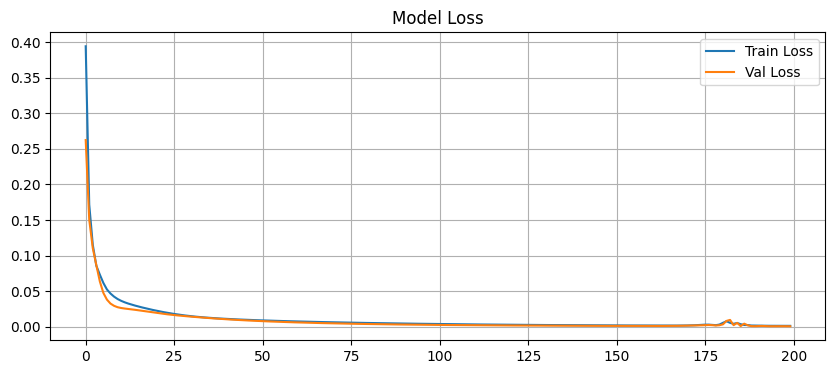

In [363]:
# --- 5. Train Model ---
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=200,
    batch_size=max(1, X_train_scaled.shape[0] // 8 if X_train_scaled.shape[0] > 0 else 1),
    validation_data=(X_val_scaled, y_val_scaled),
    # callbacks=[early_stopping],
    verbose=1
)
plt.figure(figsize=(10,4)); plt.plot(history.history['loss'], label='Train Loss'); plt.plot(history.history['val_loss'], label='Val Loss'); plt.title('Model Loss'); plt.legend(); plt.grid(True); plt.show()


# --- Auto-Regressive Prediction Function (WITH acc_10 input) ---
def predict_auto_regressively_with_acc10(model_to_use,
                                         unscaled_dynamic_features_sample, # Shape: (seq_len, num_dynamic_features)
                                         unscaled_acc_0,
                                         unscaled_acc_10, # New argument
                                         x_dynamic_scaler_model, y_acc_scaler_model,
                                         seq_len, num_dyn_feat):
    """
    Generates a sequence auto-regressively WITH acc_10 as input.
    Number of accuracy-like features in X is 3 (acc0_feat, acc10_feat, lagged_acc_feat)
    Total features = num_dyn_feat + 3
    """
    scaled_dynamic_features = x_dynamic_scaler_model.transform(unscaled_dynamic_features_sample)
    scaled_acc_0_val = y_acc_scaler_model.transform(np.array([[unscaled_acc_0]]))[0,0]
    scaled_acc_10_val = y_acc_scaler_model.transform(np.array([[unscaled_acc_10]]))[0,0] # Scale acc_10

    scaled_acc_0_feat_repeated = np.tile(scaled_acc_0_val, (seq_len, 1))
    scaled_acc_10_feat_repeated = np.tile(scaled_acc_10_val, (seq_len, 1)) # New repeated feature

    # Initialize input_X: Order: dynamic_features, acc_0, acc_10, lagged_actual_accuracy
    current_input_X = np.zeros((1, seq_len, num_dyn_feat + 3)) # +3 for acc0, acc10, lagged_acc
    current_input_X[0, :, :num_dyn_feat] = scaled_dynamic_features
    current_input_X[0, :, num_dyn_feat] = scaled_acc_0_feat_repeated[:,0]     # acc0_feat
    current_input_X[0, :, num_dyn_feat + 1] = scaled_acc_10_feat_repeated[:,0] # acc10_feat

    last_predicted_acc_scaled = scaled_acc_0_val
    generated_sequence_scaled = np.zeros(seq_len)

    for t in range(seq_len):
        # lagged_acc_feat is at index num_dyn_feat + 2
        current_input_X[0, t, num_dyn_feat + 2] = last_predicted_acc_scaled 
        
        prediction_all_steps_scaled = model_to_use.predict(current_input_X, verbose=0)
        current_step_pred_scaled = prediction_all_steps_scaled[0, t, 0]
        
        generated_sequence_scaled[t] = current_step_pred_scaled
        last_predicted_acc_scaled = current_step_pred_scaled
        
    return y_acc_scaler_model.inverse_transform(generated_sequence_scaled.reshape(-1,1)).flatten()

In [364]:
# --- 6. Evaluate with Auto-Regressive Prediction on VALIDATION Set ---
print("\nPerforming auto-regressive benchmark on VALIDATION set (with acc_10 input)...")
all_auto_regressive_preds_val = []
all_y_val_original = []

for i in range(X_val_all_samples.shape[0]):
    unscaled_dyn_features = X_val_all_samples[i, :, :num_dynamic_features]
    # acc_0 is at index num_dynamic_features
    unscaled_acc0_for_sample = X_val_all_samples[i, 0, num_dynamic_features]
    # acc_10 is at index num_dynamic_features + 1
    unscaled_acc10_for_sample = X_val_all_samples[i, 0, num_dynamic_features + 1]

    predicted_curve = predict_auto_regressively_with_acc10(
        model,
        unscaled_dyn_features,
        unscaled_acc0_for_sample,
        unscaled_acc10_for_sample, # Pass acc_10
        x_dynamic_scaler, y_acc_scaler,
        sequence_length, num_dynamic_features
    )
    all_auto_regressive_preds_val.append(predicted_curve)
    y_val_original_sample = y_val_all_samples[i].flatten()
    all_y_val_original.append(y_val_original_sample)

all_auto_regressive_preds_val = np.array(all_auto_regressive_preds_val)
all_y_val_original = np.array(all_y_val_original)

from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_ar_val = mean_absolute_error(all_y_val_original.flatten(), all_auto_regressive_preds_val.flatten())
mse_ar_val = mean_squared_error(all_y_val_original.flatten(), all_auto_regressive_preds_val.flatten())
print(f"\nAuto-Regressive VALIDATION MAE (original scale): {mae_ar_val:.4f}")
print(f"Auto-Regressive VALIDATION MSE (original scale): {mse_ar_val:.4f}")


Performing auto-regressive benchmark on VALIDATION set (with acc_10 input)...

Auto-Regressive VALIDATION MAE (original scale): 0.0395
Auto-Regressive VALIDATION MSE (original scale): 0.0028



Visualizing predictions for 2 validation samples (with acc_10 input)...


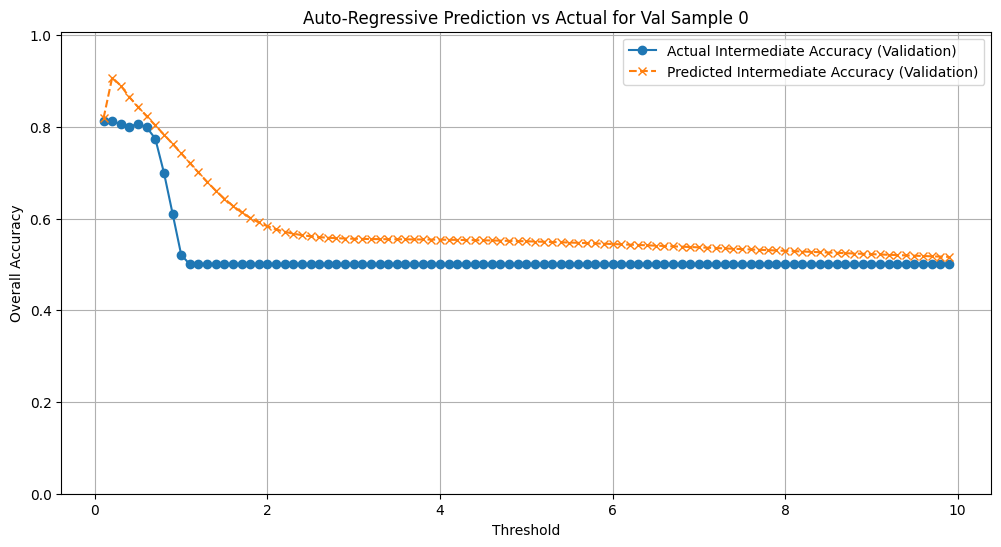

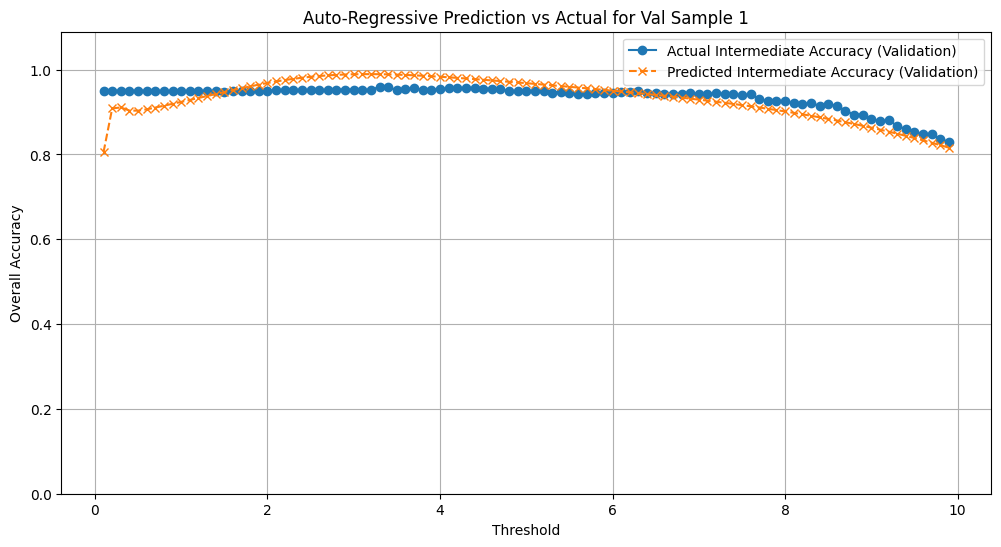

In [365]:
# --- 7. Visualize Predictions on VALIDATION Set ---
num_samples_to_plot = min(3, X_val_all_samples.shape[0])
print(f"\nVisualizing predictions for {num_samples_to_plot} validation samples (with acc_10 input)...")
for i in range(num_samples_to_plot):
    plt.figure(figsize=(12, 6))
    plt.plot(INTERMEDIATE_THRESHOLDS, all_y_val_original[i], label='Actual Intermediate Accuracy (Validation)', marker='o', linestyle='-')
    plt.plot(INTERMEDIATE_THRESHOLDS, all_auto_regressive_preds_val[i], label='Predicted Intermediate Accuracy (Validation)', marker='x', linestyle='--')

    plt.title(f"Auto-Regressive Prediction vs Actual for Val Sample {i}")
    plt.xlabel("Threshold")
    plt.ylabel("Overall Accuracy")
    plt.legend()
    plt.grid(True)
    min_val = min(0, np.min(all_y_val_original[i]) - 0.1, np.min(all_auto_regressive_preds_val[i]) - 0.1 if len(all_auto_regressive_preds_val[i]) > 0 else 0)
    max_val = max(1, np.max(all_y_val_original[i]) + 0.1, np.max(all_auto_regressive_preds_val[i]) + 0.1 if len(all_auto_regressive_preds_val[i]) > 0 else 1)
    plt.ylim(min_val, max_val)
    plt.show()